# Asymmetric Experience Reply (ER_AML - ER_ACE)

Import of libraries.

In [1]:
import json

from src.utils.plot import plot_over_experiences, plot_forgetting, plot_accuracy_tables, plot_general_results, plot_bn_stats_over_epochs, plot_bn_difference_over_epochs

## Paper analysis
Analysis related to the paper [NEW INSIGHTS ON REDUCING ABRUPT REPRESENTATION CHANGE IN ONLINE CONTINUAL LEARNING](https://arxiv.org/abs/2104.05025) on split CIFAR100.

### 1. Project objectives

ER_ACE and ER_AML are two techniques used in deep continual learning field. Both of them are able to compute the loss function in an asymmetric way so dividing it in a sum of two losses:
- `loss_in`: Loss computed on new minibatch of the current experience
- `loss_buffer`: Loss computed on a replay memory called buffer

Both the techniques uses replay memory that is balanced over classes and compute the `loss_buffer` using cross entropy loss. The difference between the two methods are in the `loss_in`:

- `ER_AML`: it is able to sample positive and negative examples from memory related to each example in the current minibatch and compute the exponential of cosine similarity between each example of minibatch and related positive and negative examples. In practice, we want to minimize the distance between new examples and stored examples of the same class. The similarity is computed between features of inputs; in fact the model should provide hidden features used to compare examples and compute their similarity.
- `ER_ACE`: it is able to approximate the ER_AML behavior using cross entropy. It computes the cross entropy loss of new minibatch examples with respect to related targets but masking to zero classes already seen.

Resources used during implementation are:
- [avalanche](https://github.com/ContinualAI/avalanche): For strategy construction and ResNet18 model
- [continual-learning-baselines](https://github.com/ContinualAI/continual-learning-baselines): For test comparisons and hyperparameters selection
- [AML](https://github.com/pclucas14/AML): Official repository of the paper. Used for AML and ACE strategy construction

### 2. Any critical part of the implementation

Management of avalanche buffer replay. The two techniques (ER_AML and ER_ACE) use a replay buffer (balanced reservoir sampling) that is updated at each iteration while in avalanche the replay buffer is updated each experience.

### 3. Overview of the results

It's done a model selection using grid search algorithms and results are saved in `paper_results.json` file. Validation is done using holdout approach with validation percentage that is the 10% of training set. After having found best hyperparameters that maximizes AAA metric we retrain the model from scratch on all the training stream and evaluate it on test stream. Hyperparameters tested in model selection phase are the same of the paper (and related code). In particular for ER_AML they are:
- strategy_train_mb_size=[10],
- strategy_eval_mb_size=[10],
- strategy_train_epochs=[1],
- strategy_mem_size=[100],
- strategy_batch_size_mem=[10],
- strategy_temp=[0.1, 0.2],
- sgd_lr=[0.1, 0.01, 0.001],
- sgd_momentum=[0]

and the same except `strategy_temp` for ER_ACE.

Import paper results data.

In [2]:
with open('paper_results.json') as file:
    paper_results = json.load(file)

paper_test_results = {k: v['test'] for k, v in paper_results.items()}

Here are shown test results related to ER_ACE and ER_AML developed for this project compared with Naive, GDumb and ER_ACE_AVALANCHE strategies. ER_ACE_AVALANCHE and ER_ACE are the same methods that differ only in the update of the replay buffer:
- ER_ACE_AVALANCHE uses the avalanche balanced reservoir sampling method that update the buffer with the new experience before the current one except for the first one.
- ER_ACE (as ER_AML) uses the new balanced reservoir sampling implementation and the instance of this buffer replay method is updated after each minibatch iteration with the current minibatch as described in the paper and related code.

From results, we can tell that ER_ACE is the best strategy according AAA and accuracy metrics. ER_ACE_AVALANCHE is better than ER_AML in terms of AAA while according accuracy ER_AML overcome the other. According to these results we can tell that using buffer replay method at each iteration helps to improving performance.

In [3]:
plot_general_results(paper_test_results)

,Naive,GDumb,ER_AML,ER_ACE,ER_ACE_AVALANCHE
AAA,11.3 %,22.14 %,27.6 %,34.59 %,28.73 %
accuracy,3.86 %,7.73 %,24.85 %,25.32 %,23.9 %
strategy_train_mb_size,10,10,10,10,10
strategy_eval_mb_size,10,10,10,10,10
strategy_train_epochs,1,1,1,1,1
sgd_lr,0.01,0.01,0.1,0.01,0.1
sgd_momentum,0,0,0,0,0
strategy_mem_size,NaN,10000,10000,10000,10000
strategy_batch_size_mem,NaN,NaN,10,10,10
strategy_temp,NaN,NaN,0.1,NaN,NaN


Plot of strategies accuracy over experiences. In the x-axis we have the experiences learned at each step while in the y-axis the mean accuracy for each experience seen up the current time. We can tell that ER_ACE is the better with its curve over the other strategies. ER_ACE_AVALANCHE seems to be slighlty better than ER_AML while GDumb and Naive are the worst ones. In general ER_AML, ER_ACE and ER_ACE_AVALANCHE strategies seems to converge more or less after 3 experiences.

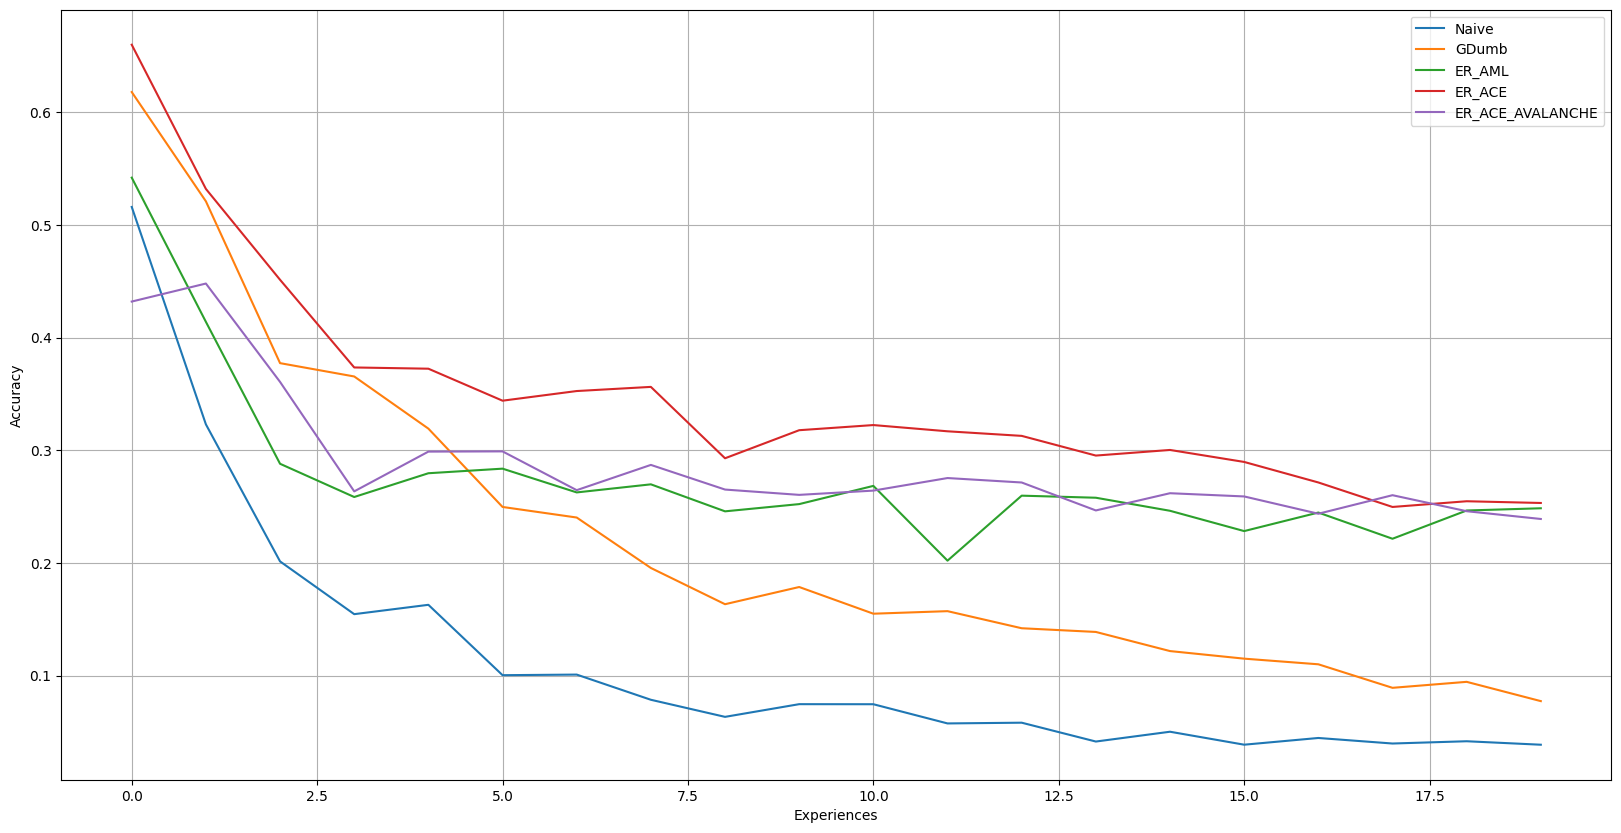

In [4]:
plot_over_experiences(
    {k: [sum(x.values()) / len(x.values()) for x in v['info']] for k, v in paper_test_results.items()},
    xlabel='Experiences',
    ylabel='Accuracy'
)

Plot of strategies forgetting. As expected Naive strategy hav the higher forgetting and GDumb follows it with an high value. ER_ACE and ER_ACE_AVALANCHE seems to have a low level of forgetting that is similar (ER_ACE is slightly better). ER_AML is the unique strategy that presents a backward transfer.

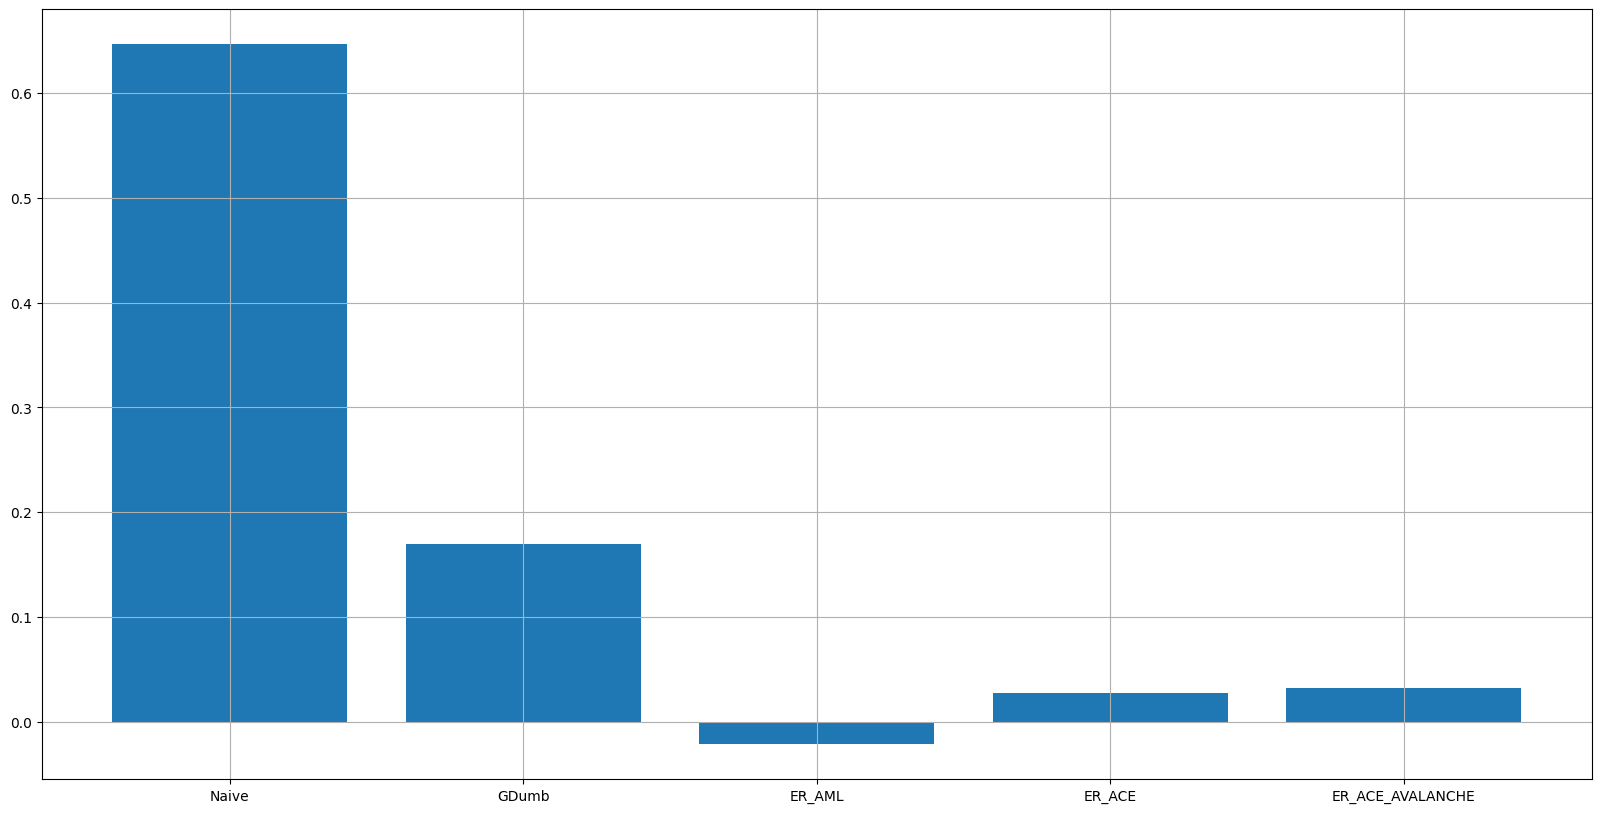

In [5]:
plot_forgetting(paper_test_results)

Plot of first experience accuracy over new experiences learning. According to the first experience we can understand that more or less ER_ACE, ER_ACE_AVALANCHE and ER_AML behaves more or less in the same way (ER_ACE is slightly better). Instead, GDumb seems to decrease after 10 experiences and Naive strategy forget completely the first experience after training the second one.

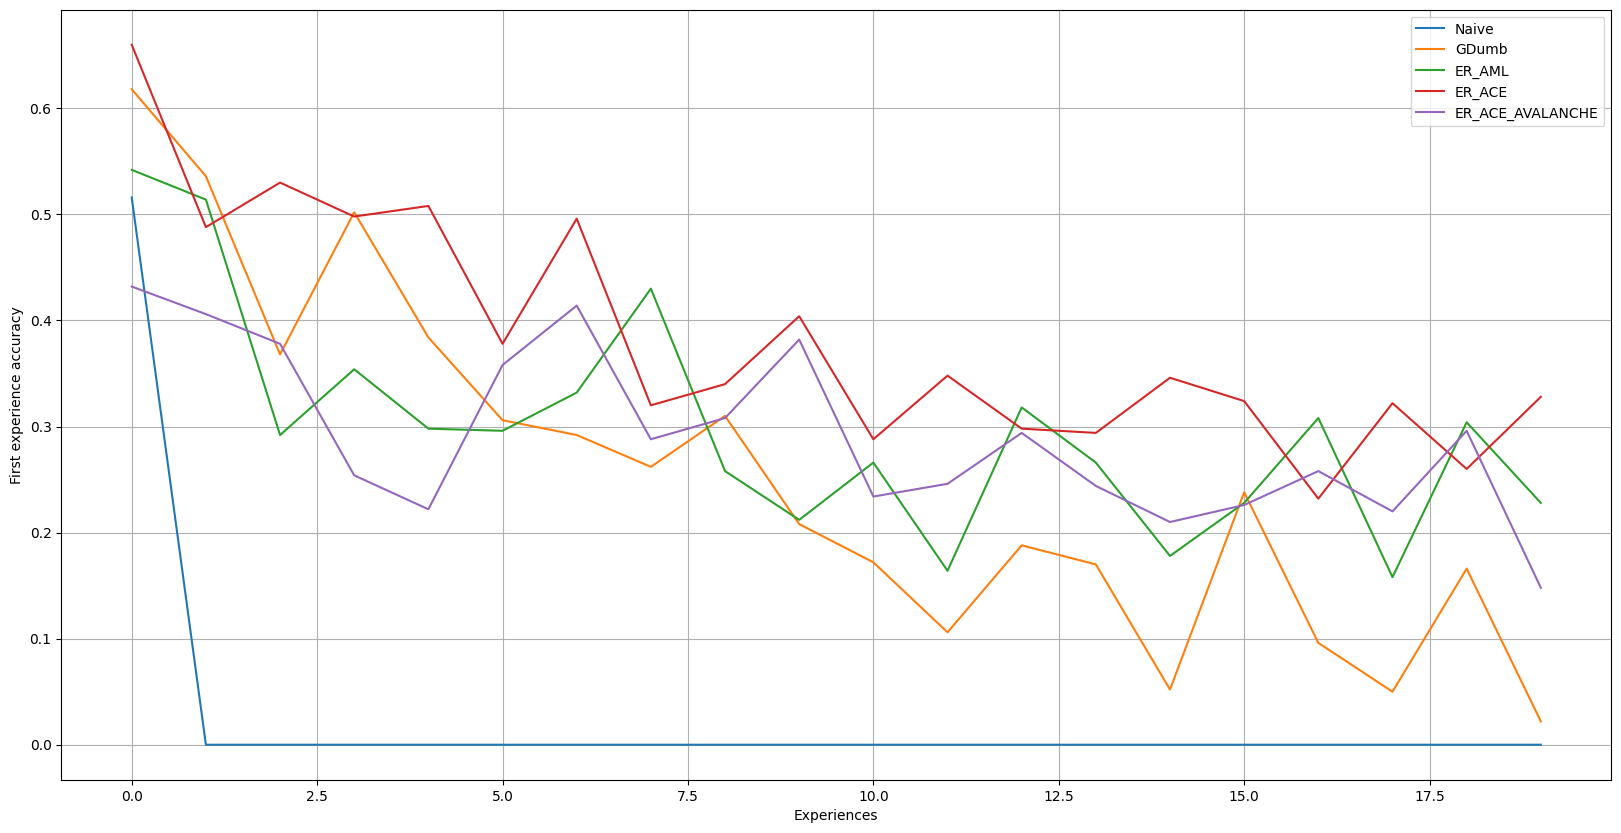

In [6]:
plot_over_experiences(
     {
         k: [x['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000']
             for x in v['info']]
         for k, v in paper_test_results.items()
     },
    xlabel='Experiences',
    ylabel='First experience accuracy'
)

Accuracy table of experiences over time for each strategy.
According to the tables for each strategy we can tell that:
- Naive: when the strategy learn a new experience completely forget the previous ones.
- GDumb: better than Naive but there is also a forgetting behavior after some epochs that squeeze down performances for older experience.
- ER_AML: for the main part of experiences we can see a backward transfer.
- ER_ACE: in general this strategy is able to keep a good trade-off between forgetting and backward transfer.
- ER_ACE_AVALANCHE: similar results with respect ER_ACE.

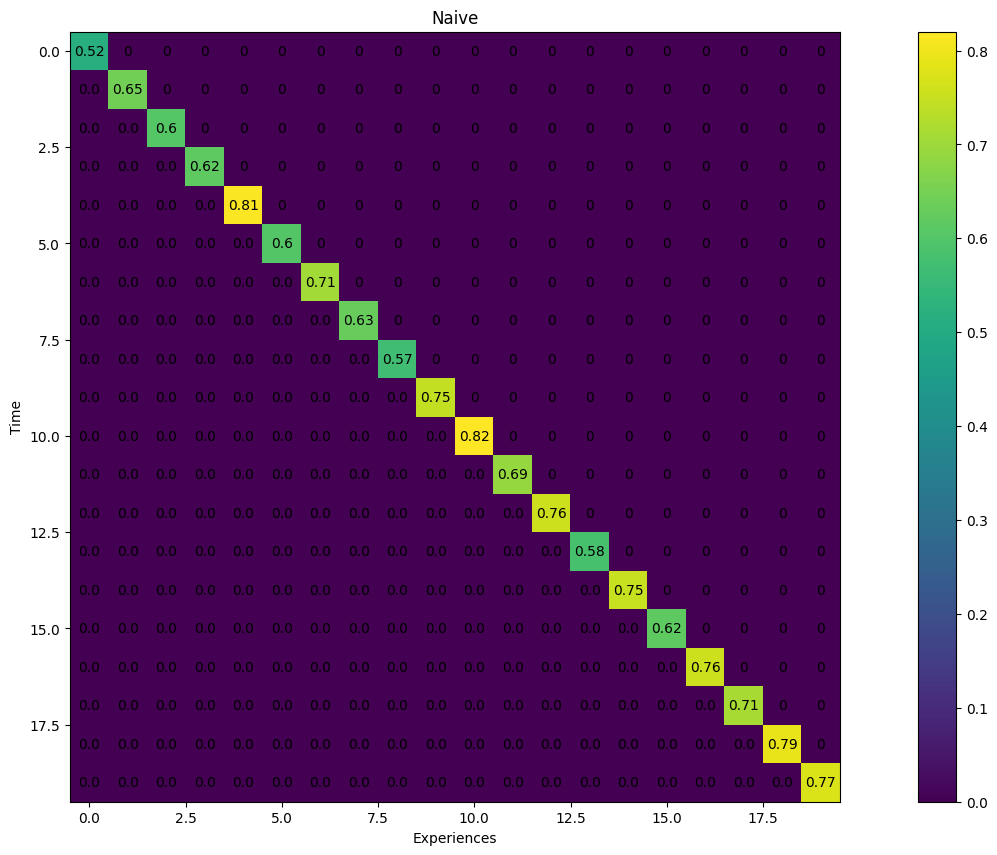

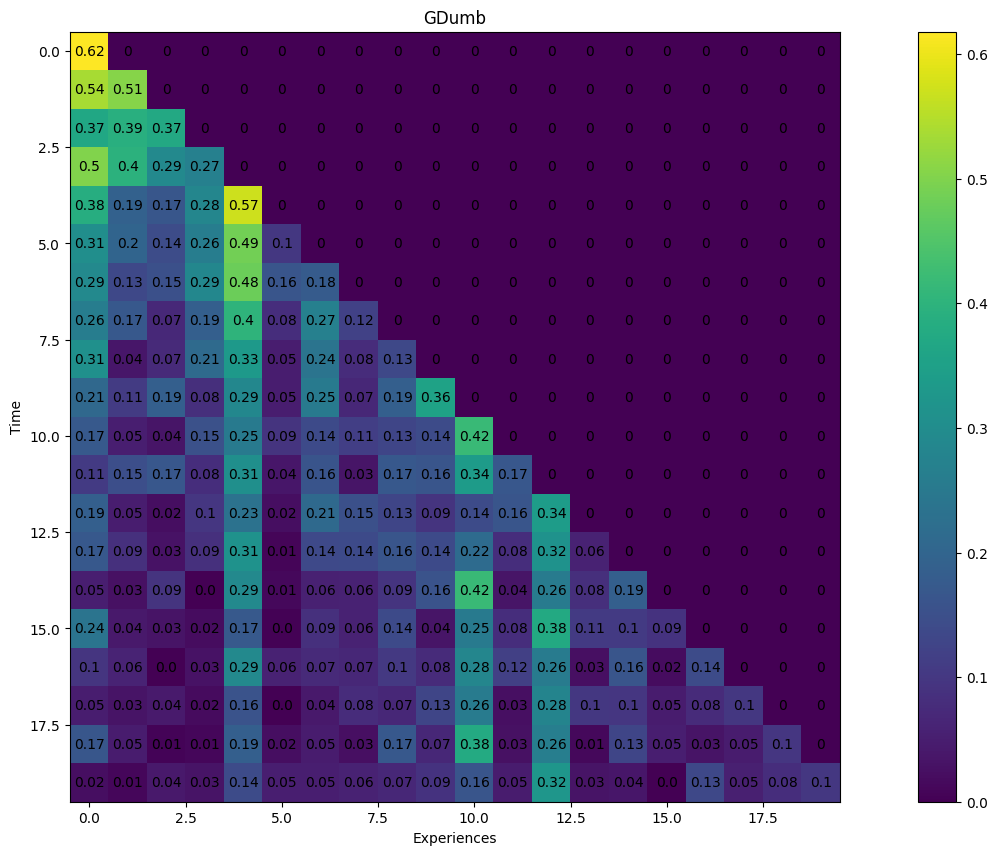

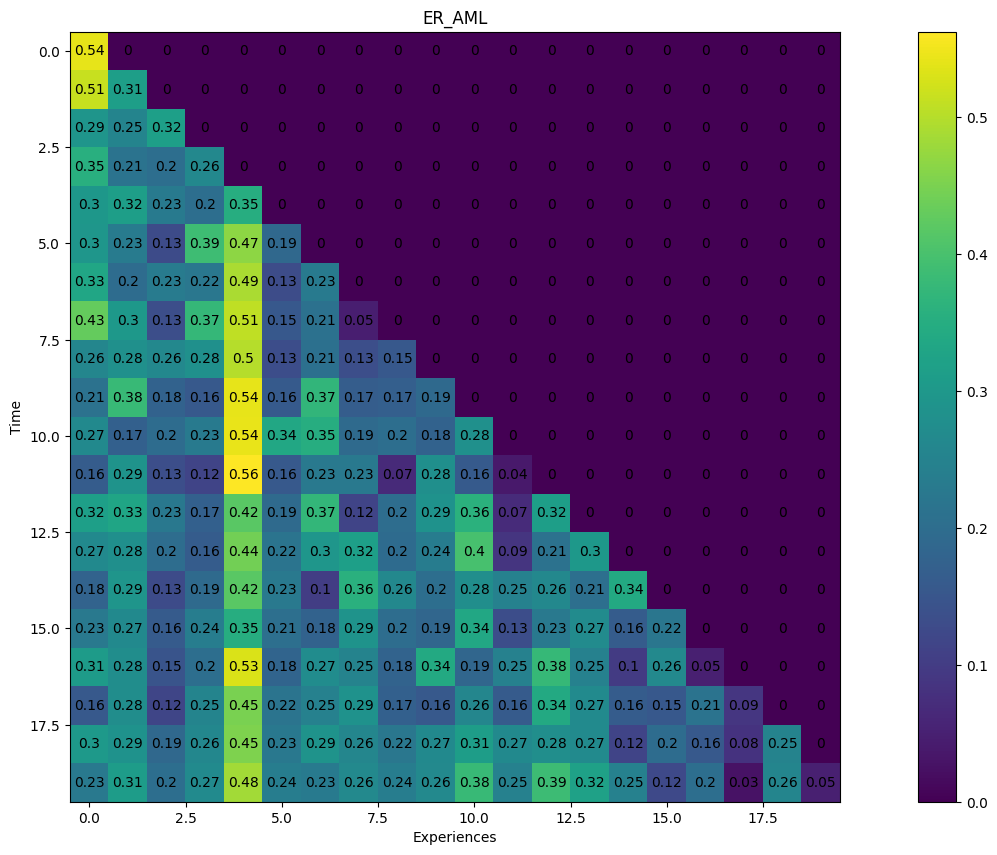

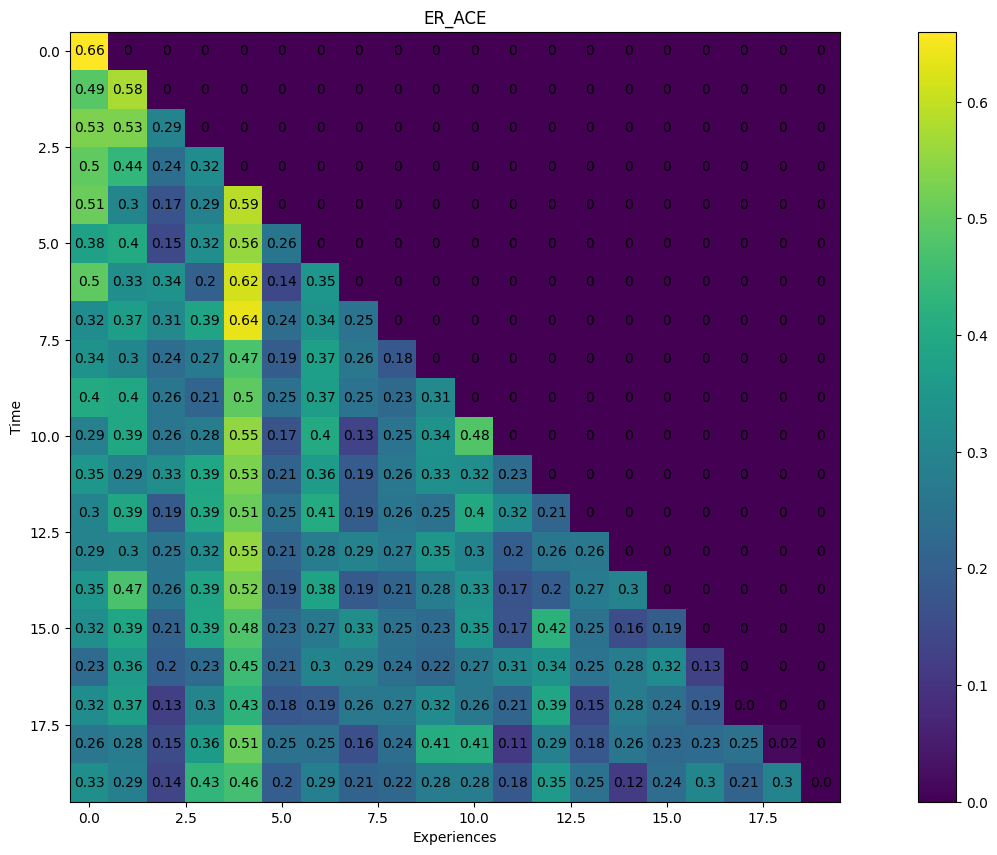

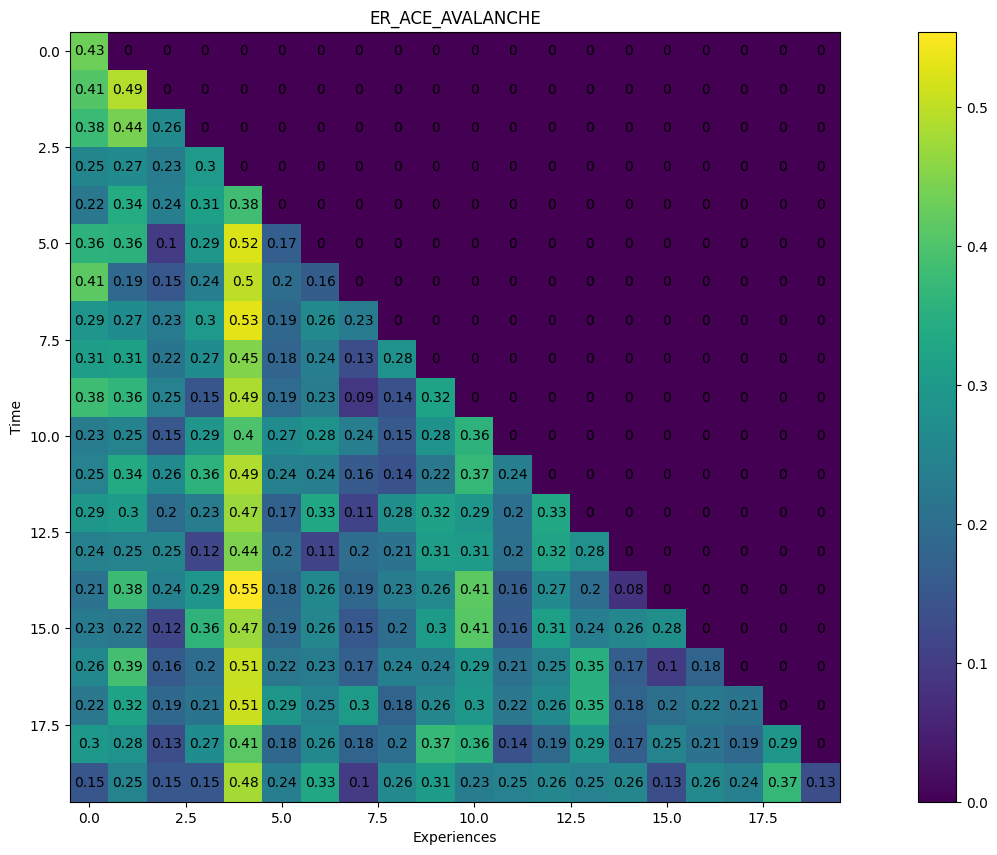

In [7]:
plot_accuracy_tables(paper_test_results)

### 4. Conclusion
We can conclude this analysis with the following considerations:
- ER_ACE and ER_AML methods overcome Naive and GDumb baselines.
- ER_ACE seems to be better with respect the avalanche version of ER_ACE_AVALANCHE, so is better to use a buffer replay that is updated after each minibatch iteration.
- ER_AML is slightly worse with respect to ER_ACE in terms of accuracy but has `backward transfer`.

# N-Iters analysis
Analysis of ER_AML and ER_ACE strategies on changing of niters parameter. The analysis focus on related change in terms of batch normalization features.
`niters` is the hyperparam of iterations done for each new minibatch. The loss for each of these iterations is computed with the same new minibatch and a random sampling of buffer replay.

Loading niters results data.

In [8]:
with open('niters_results.json') as file:
    niters_results = json.load(file)

General results in terms of AAA and accuracy related to ER_AML and ER_ACE with niters set to 1, 2 and 4. We can tell that:
- AAA: grows with the number of niters. The growing seems to have a logarithmic behavior.
- accuracy: seems to be higher with 2 niters; in fact the mean of accuracies after last learned experience tends to decrease increasing the number of niters from 2 to 4.

In [9]:
plot_general_results(niters_results)

,ER_ACE [niters=1],ER_ACE [niters=2],ER_ACE [niters=4],ER_AML [niters=1],ER_AML [niters=2],ER_AML [niters=4]
AAA,29.22 %,36.9 %,38.72 %,27.6 %,34.64 %,36.98 %
accuracy,22.95 %,28.69 %,26.22 %,24.85 %,27.66 %,24.89 %
strategy_train_mb_size,10,10,10,10,10,10
strategy_eval_mb_size,10,10,10,10,10,10
strategy_train_epochs,1,1,1,1,1,1
strategy_mem_size,10000,10000,10000,10000,10000,10000
strategy_batch_size_mem,10,10,10,10,10,10
strategy_n_iters,1,2,4,1,2,4
sgd_lr,0.1,0.1,0.1,0.1,0.1,0.1
sgd_momentum,0,0,0,0,0,0


Plot of strategies accuracy over experiences. Seem that ER_AML and ER_ACE with the same number of niters have more or less the same curve. Another observation could be that with niters=1 the curve is lower and increasing the hyperparam it starts to grow in a logarithmic way.

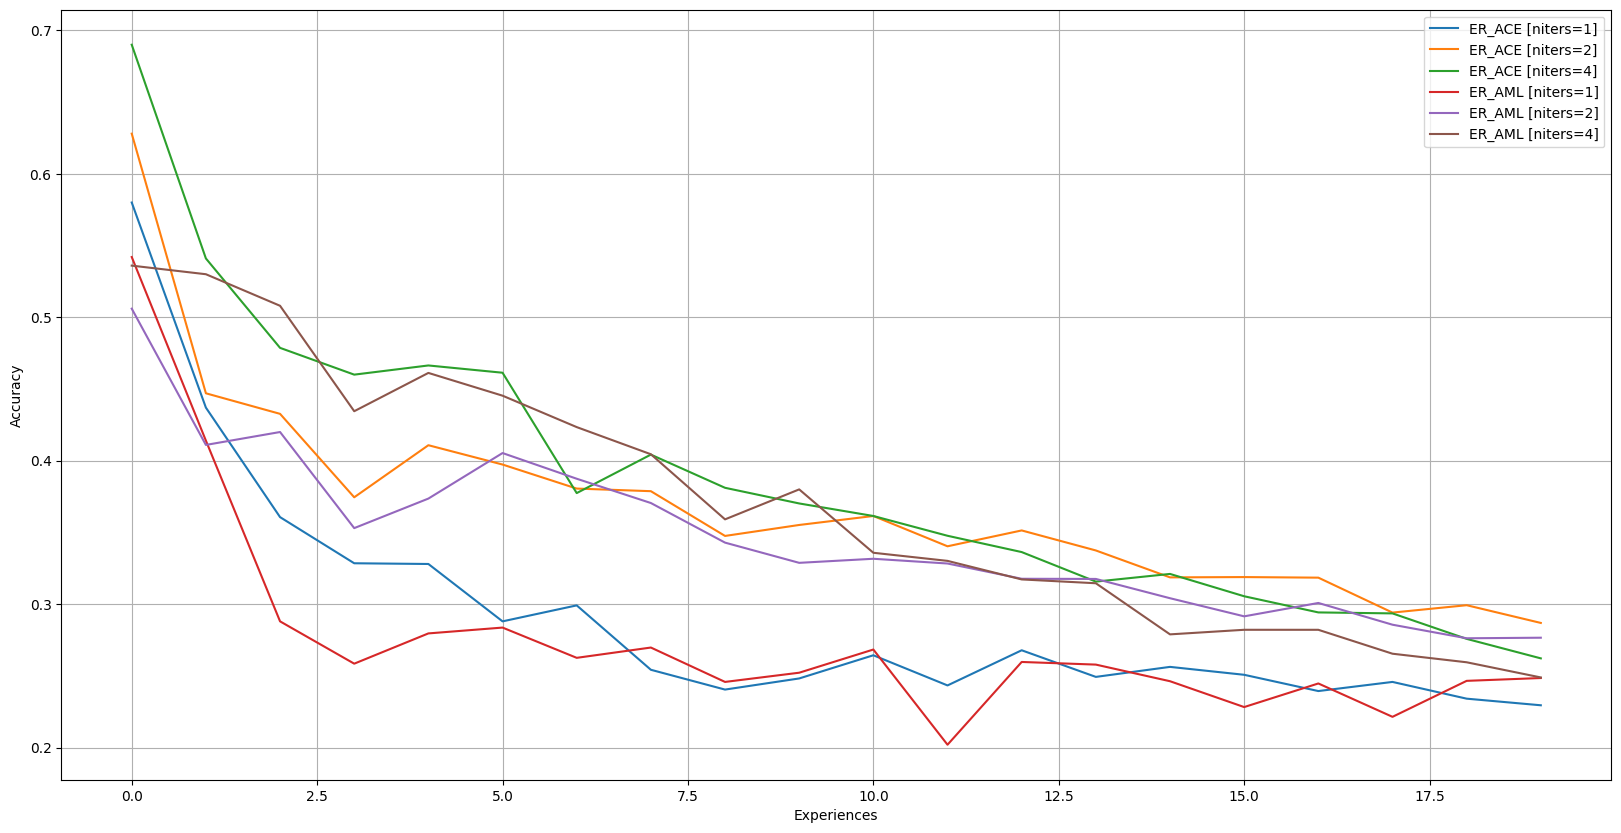

In [10]:
plot_over_experiences(
    {k: [sum(x.values()) / len(x.values()) for x in v['info']] for k, v in niters_results.items()},
    xlabel='Experiences',
    ylabel='Accuracy'
)

Plot of histogram related to the strategies forgetting. We can tell that only ER_AML with niters=1 is able to have backward transfer that is lost with the increasing of the hyperparam. In general using niters=4 brings to have an higher forgetting. This behavior can be expected because at each experience we look more times the new data so we could expect to forget the older ones.

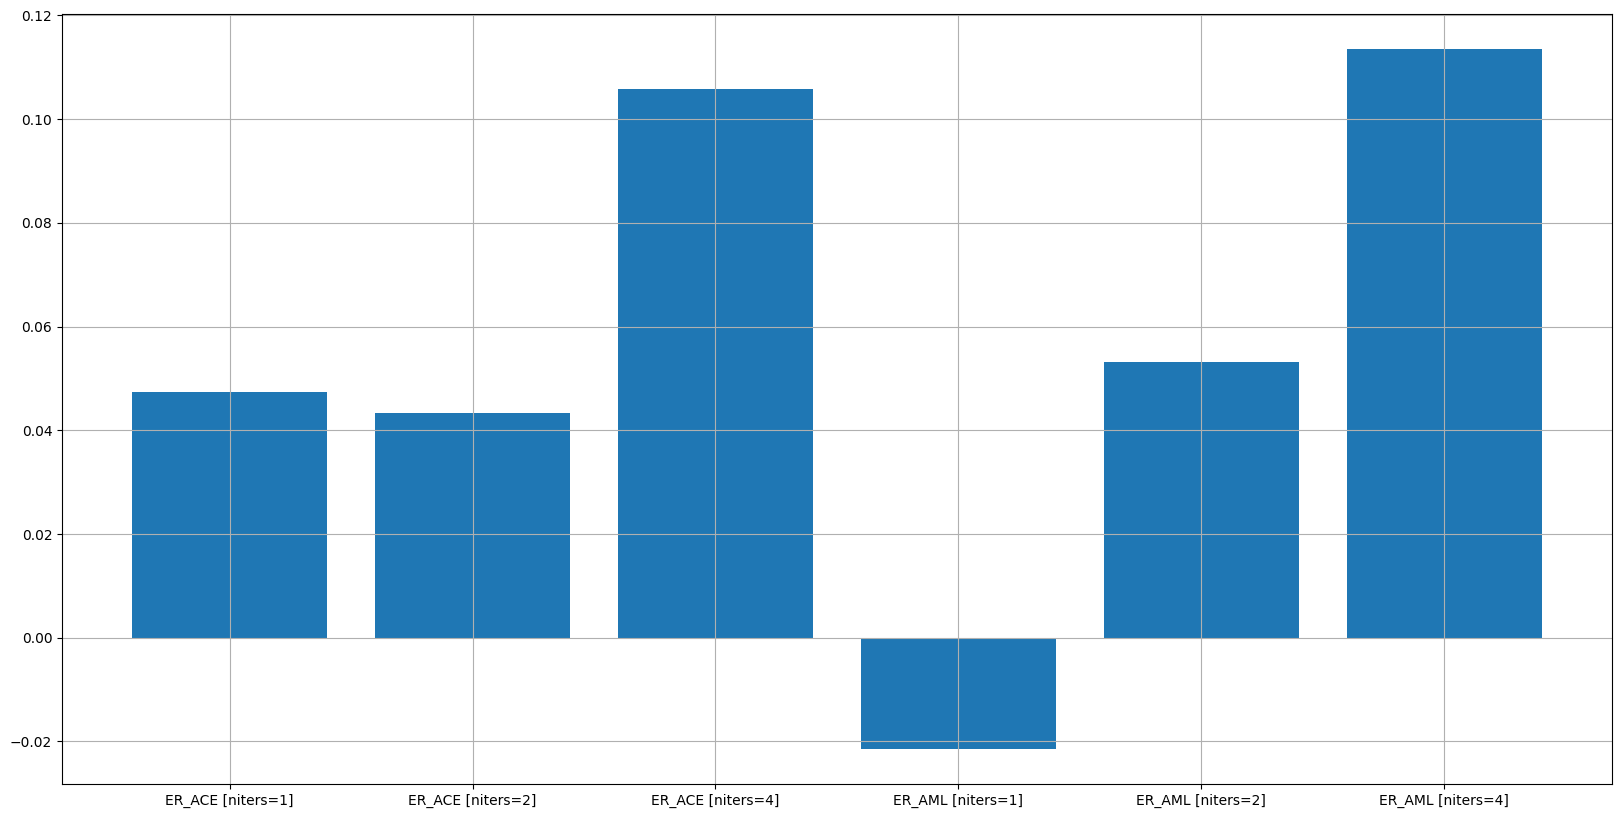

In [11]:
plot_forgetting(niters_results)

Printing of ResNet18 (model used in experiments) minibatch layers. The result is the dictionary with:
- key: number of bn layer
- value: string representation of bn layer

In [12]:
from src.model import ResNet18
import torch

dict(enumerate([l for l in ResNet18(20).modules() if type(l) is torch.nn.BatchNorm2d]))

{0: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 1: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 2: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 3: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 4: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 5: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 6: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 7: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 8: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 9: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 10: BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 11: BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track

Plots related to the mean and std of activations of new minibatch and buffer minibatch before 19th bn layer (last one) computed before each minibatch iteration. We want that distributions of new and buffer mini-batches are similar. If they are different batch normalization layer is not able to estimate well current_mean and current_var during training (EMA of new and buffer mini-batches) and this is a problem for the inference because here is used the EMA that is different from new data (related to new minibatch) and old data (related to buffer minibatch) distributions.

We plot statistics related to ER_ACE and ER_AML strategies increasing the number of `niters` (the times that we apply the backpropagation for a new mini-batch using each time a random buffer mini-batch). We expect that increasing the niters hyperparam the statistics start to become different.

As we can se, except for ER_ACE mean, in the other cases there is an increase of difference between the two lines.

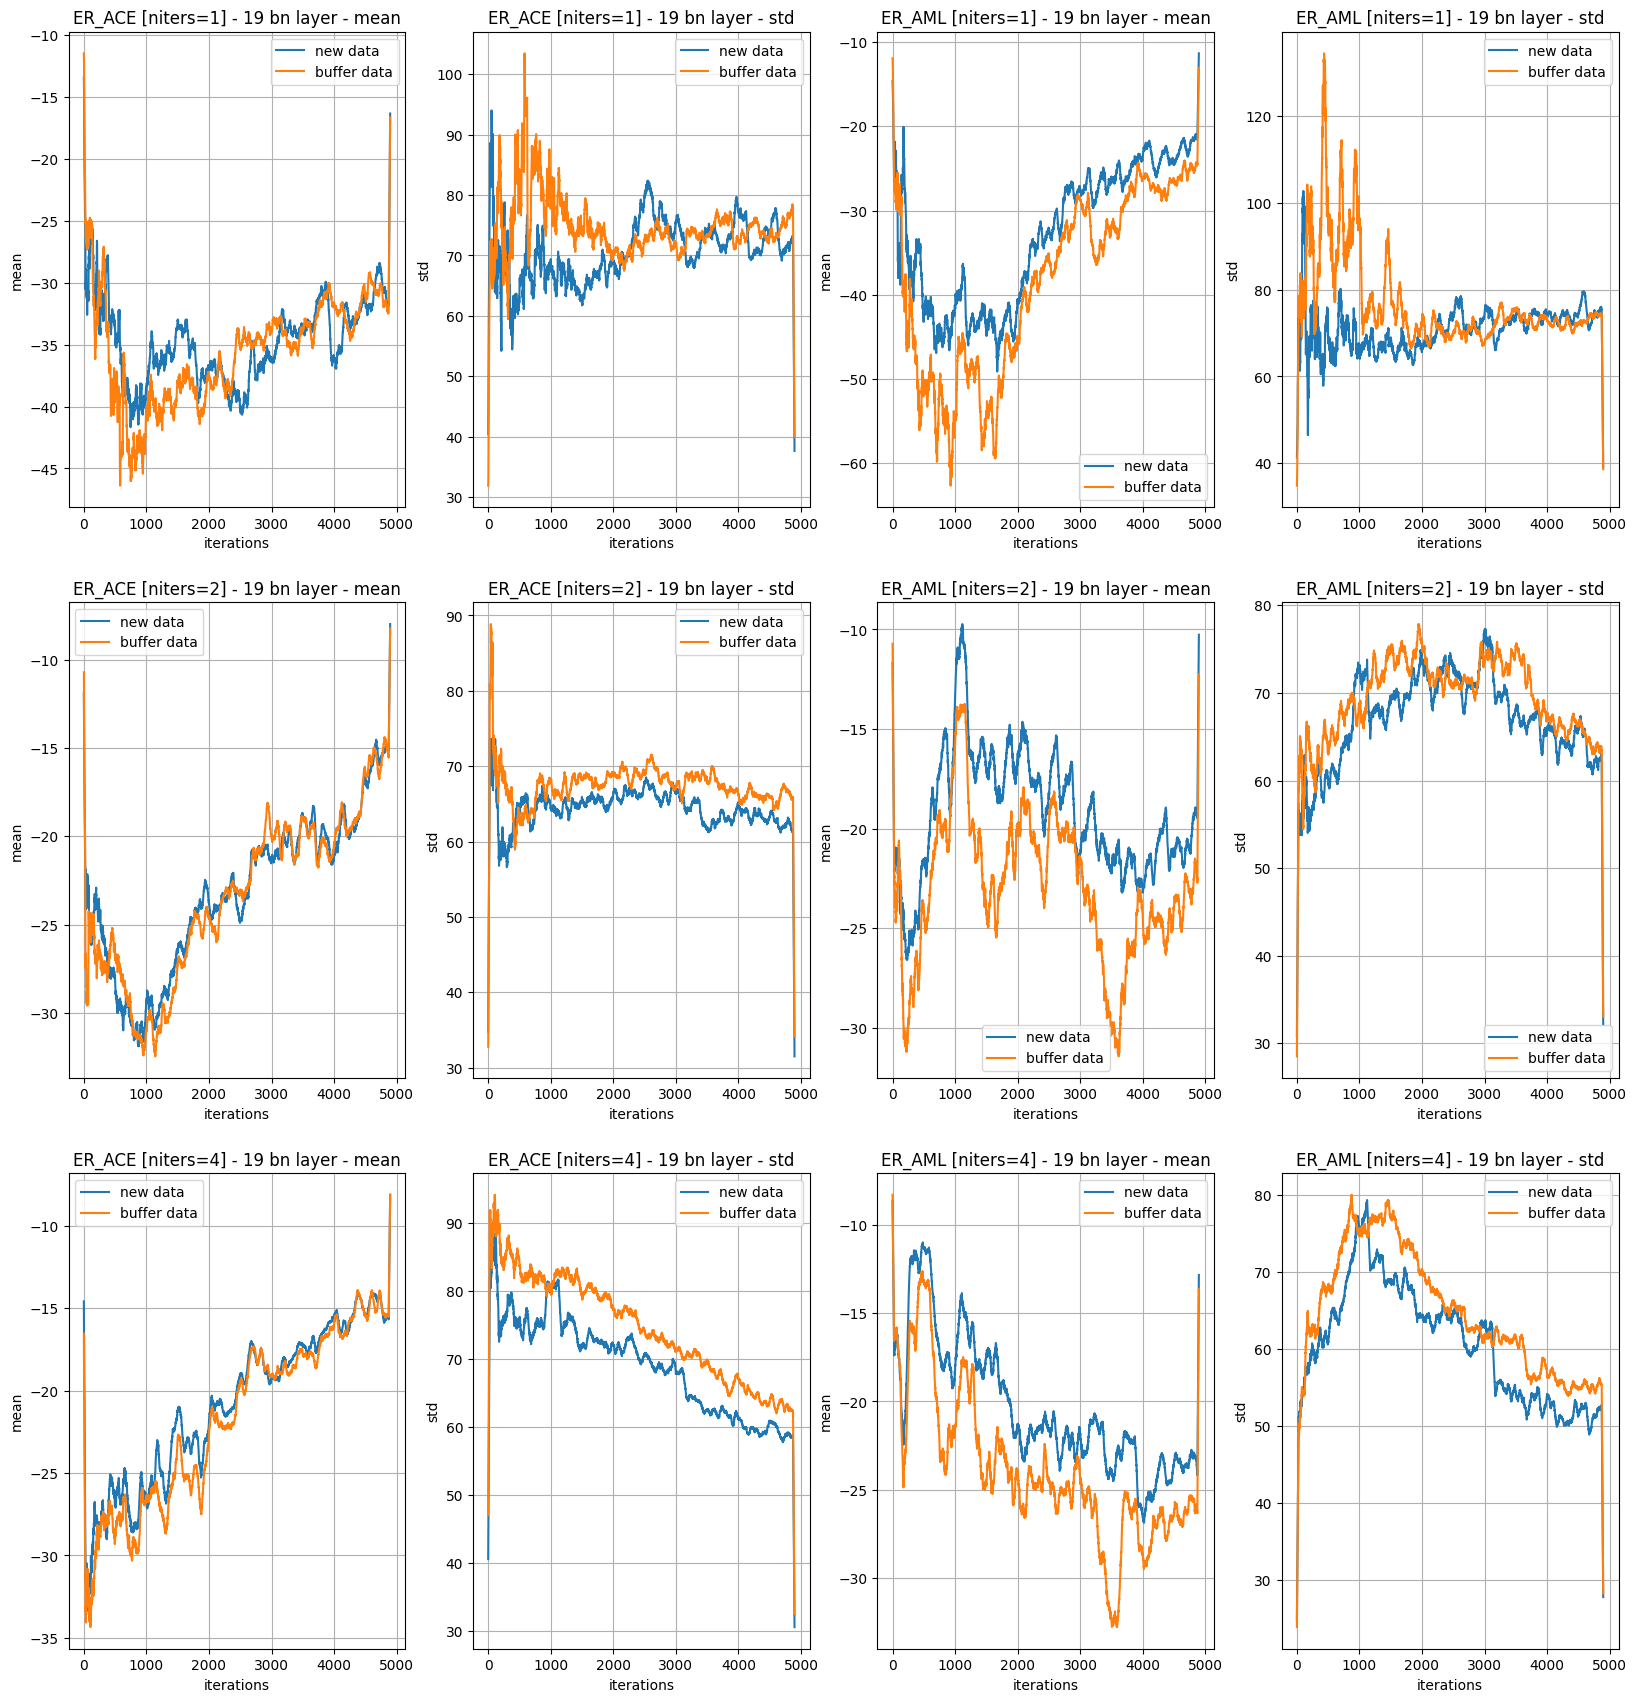

In [20]:
plot_bn_stats_over_epochs(niters_results, n_layer=19)

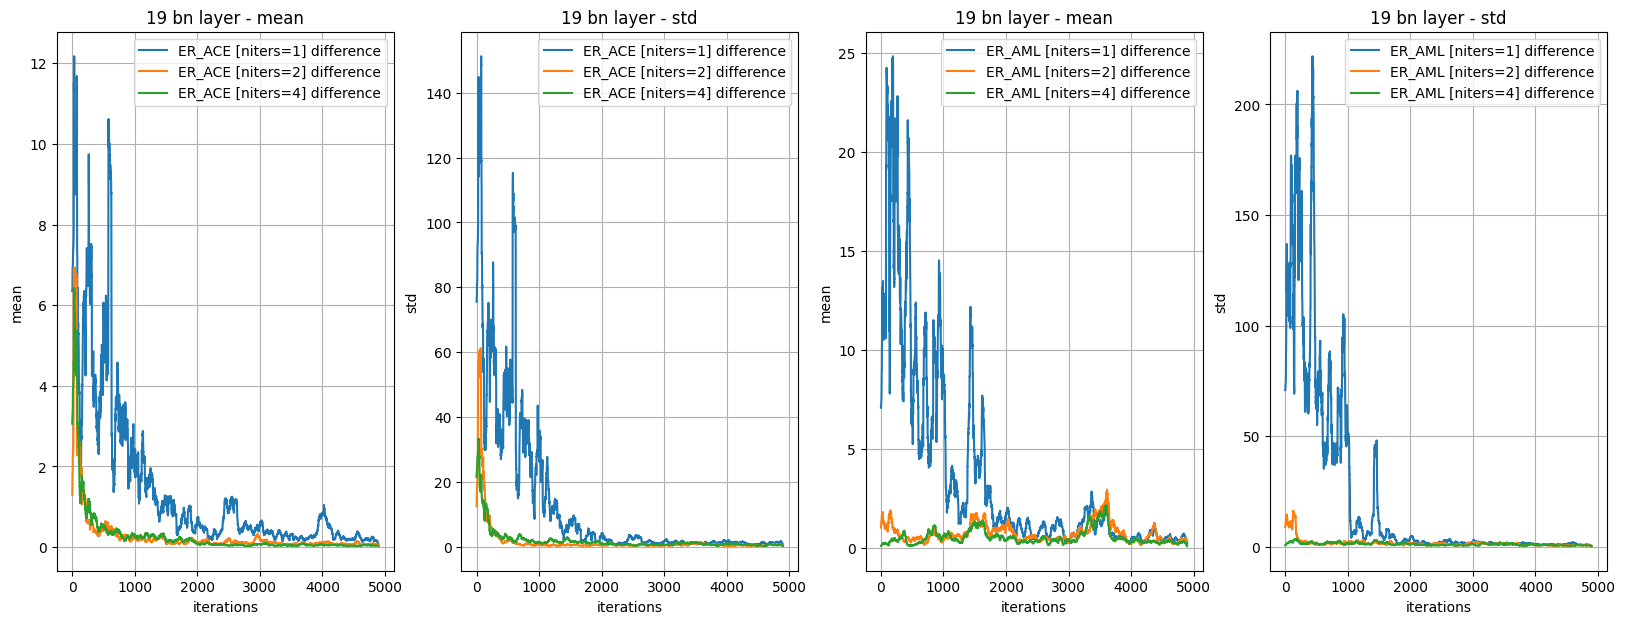

In [19]:
plot_bn_difference_over_epochs(niters_results, n_layer=19)

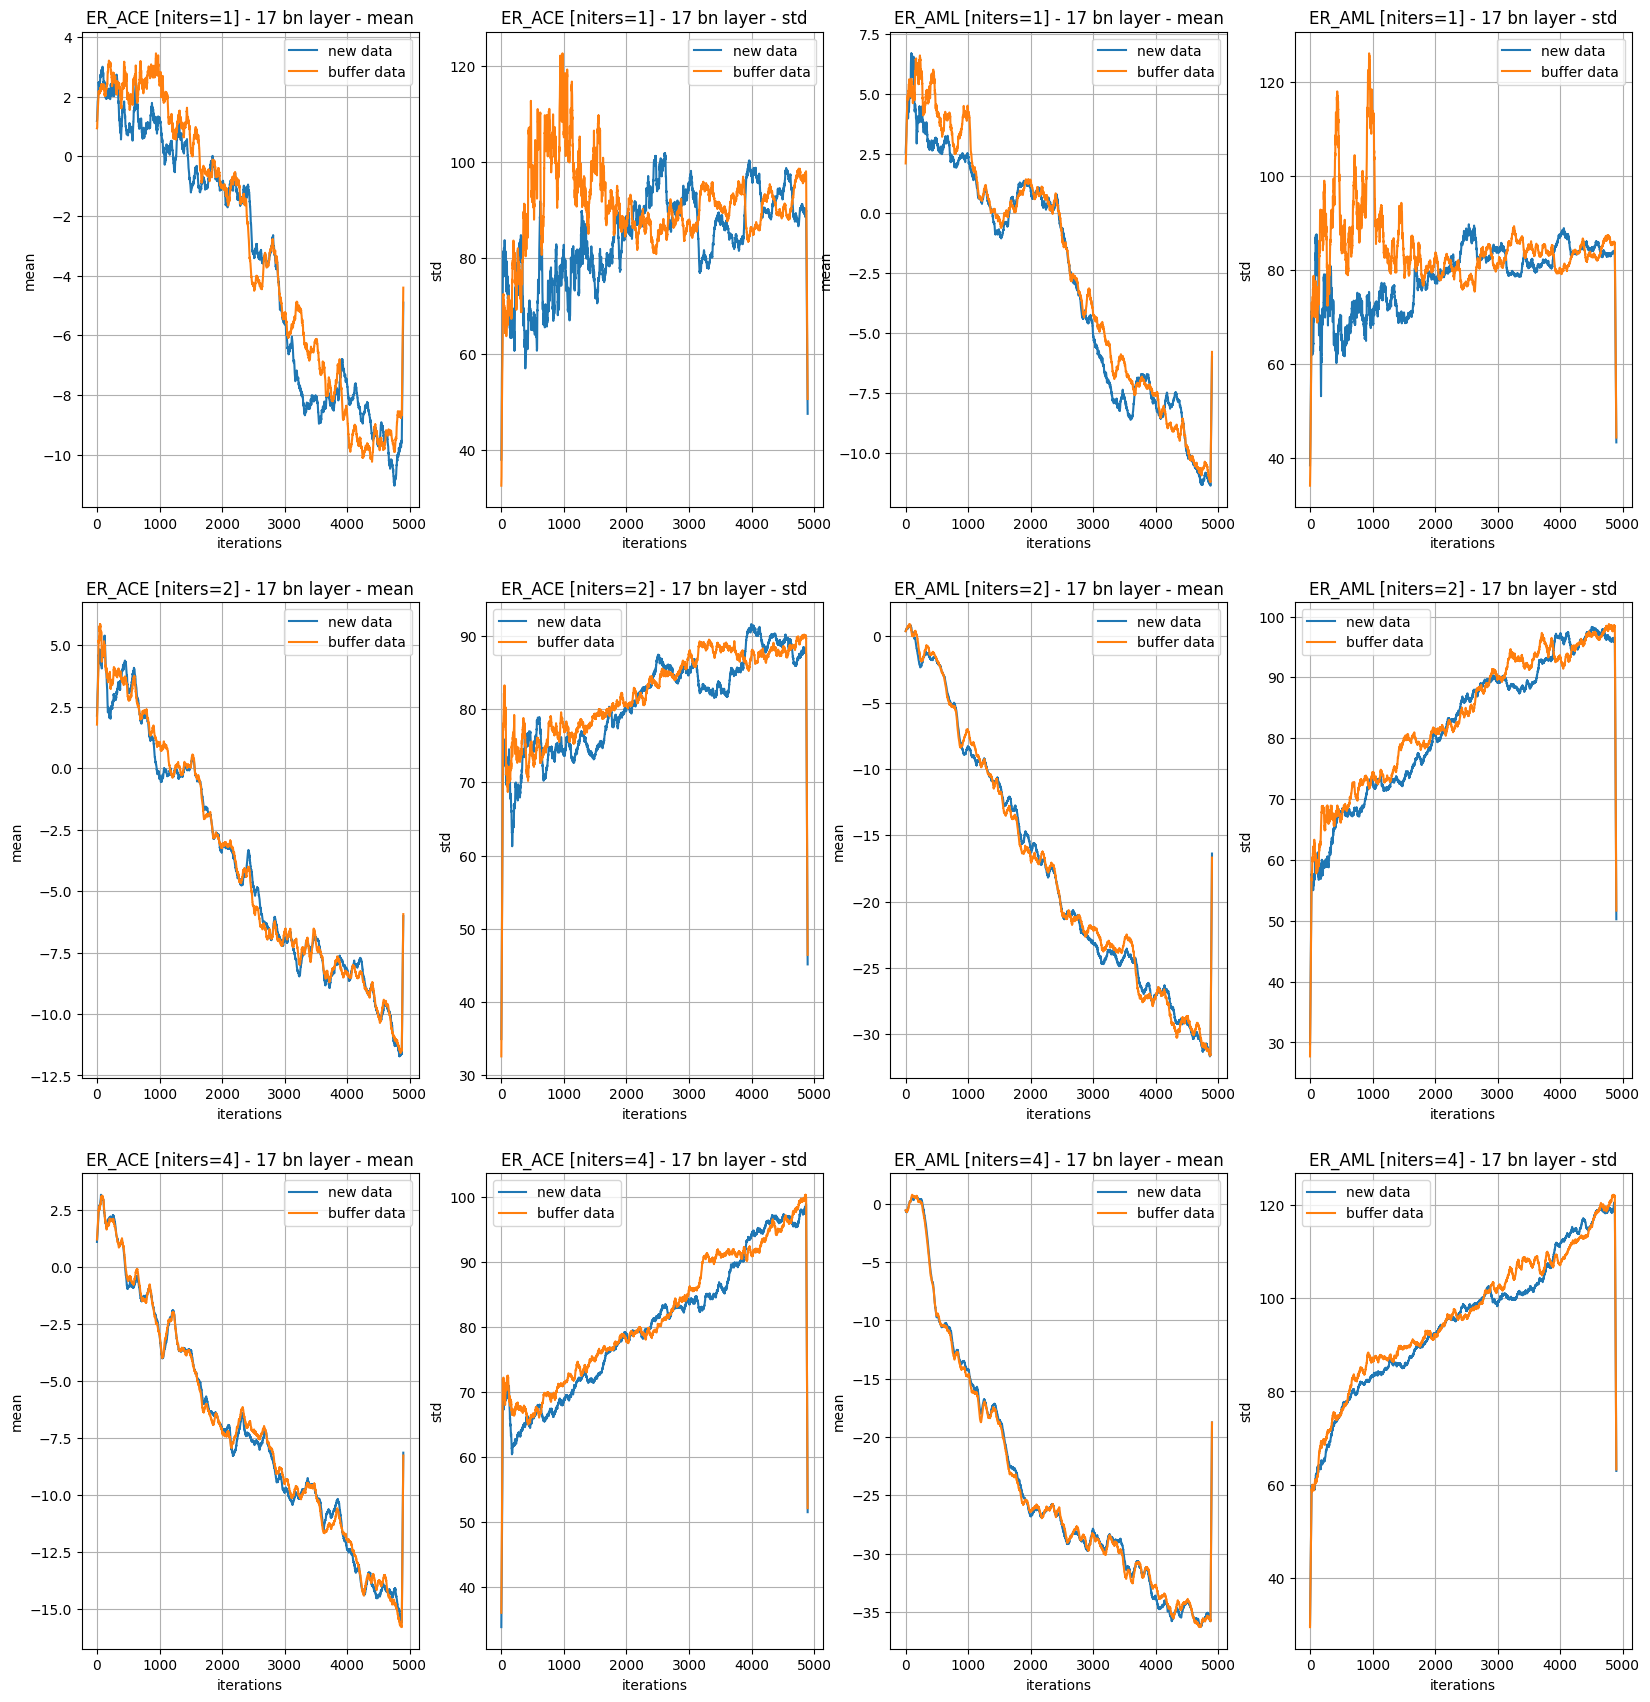

In [15]:
plot_bn_stats_over_epochs(niters_results, n_layer=17)

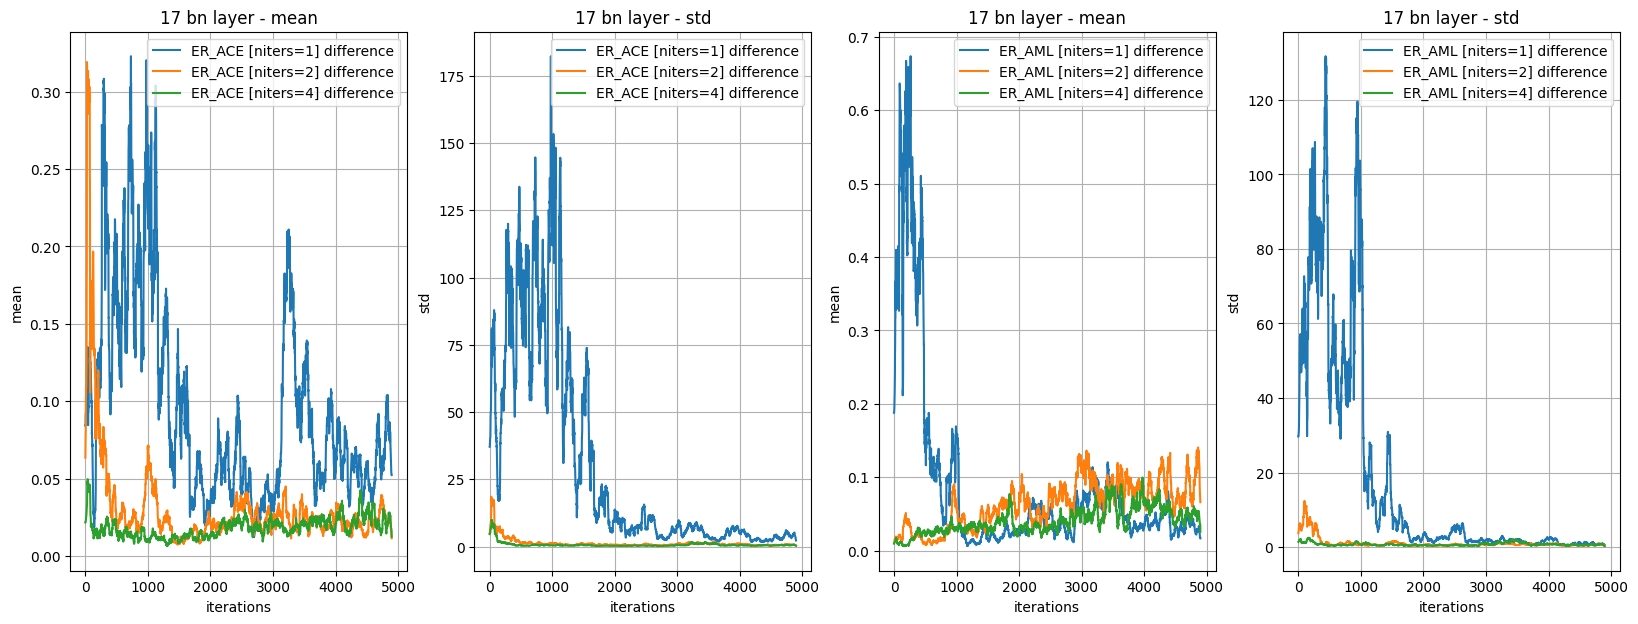

In [16]:
plot_bn_difference_over_epochs(niters_results, n_layer=17)